In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import *
from scipy.sparse.linalg import svds
import math

from recsys.preprocess import *

import functools

#from recsys.utility import *

#RANDOM_STATE = 666

#np.random.seed(RANDOM_STATE)

%matplotlib inline

In [2]:
def train_test_split(train, test_size=0.3, min_playlist_tracks=7):
    """
        Standard train_test_split, no modifications.
    """
    playlists = train[train.playlist_id.isin(target_playlists_original.playlist_id)].groupby('playlist_id').count()

    # Only playlists with at least "min_playlist_tracks" tracks are considered.
    # If "min_playlists_tracks" = 7, then 28311 out of 45649 playlists in "train" are considered.
    to_choose_playlists = playlists[playlists['track_id'] >= min_playlist_tracks].index.values


    # Among these playlists, "test_size * len(to_choose_playlists)" distinct playlists are chosen for testing.
    # If "test_size" = 0.3, then 8493 playlists are chosen for testing.
    # It's a numpy array that contains playlis_ids.
    target_playlists = np.random.choice(to_choose_playlists, replace=False, size=int(test_size * len(to_choose_playlists)))

    target_tracks = np.array([])
    indexes = np.array([])
    for p in target_playlists:
        # Choose 5 random tracks of such playlist: since we selected playlists with at least "min_playlist_tracks"
        # tracks, if "min_playlist_tracks" is at least 5, we are sure to find them.
        selected_df = train[train['playlist_id'] == p].sample(5)

        selected_tracks = selected_df['track_id'].values
        target_tracks = np.union1d(target_tracks, selected_tracks)
        indexes = np.union1d(indexes, selected_df.index.values)

    test = train.loc[indexes].copy()
    train = train.drop(indexes)

    return train, test, pd.DataFrame(target_playlists, columns=['playlist_id']), pd.DataFrame(target_tracks, columns=['track_id'])


In [3]:
import numpy as np
import scipy
from scipy.sparse import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

def dot_with_top(m1, m2, def_rows_g, top=-1, row_group=1, similarity="dot", shrinkage=0.000001, alpha=1):
    """
        Produces the product between matrices m1 and m2.
        Possible similarities: "dot", "cosine". By default it goes on "dot".
        NB: Shrinkage is not implemented...
        Code taken from
            https://stackoverflow.com/questions/29647326/sparse-matrix-dot-product-keeping-only-n-max-values-per-result-row
            and optimized for smart dot products.
    """
    m2_transposed = m2.transpose()
    
    l2 = m2.sum(axis=0) # by cols
    
    if top > 0:
        final_rows = []
        row_id = 0
        while row_id < m1.shape[0]:
            last_row = row_id + row_group if row_id + row_group <= m1.shape[0] else m1.shape[0]
            rows = m1[row_id:last_row]
            if rows.count_nonzero() > 0:
                if similarity == "cosine-old":
                    res_rows = cosine_similarity(rows, m2_transposed, dense_output=False)
                elif similarity == "cosine":
                    res_rows = csr_matrix((np.dot(rows,m2) / (np.sqrt(rows.sum(axis=1)) * np.sqrt(l2) + shrinkage)))
                elif similarity == "cosine-asym":
                    res_rows = csr_matrix((np.dot(rows,m2) / (np.power(rows.sum(axis=1),alpha) * np.power(m2.sum(axis=0),(1-alpha)) + shrinkage)))
                elif similarity == "dot-old":
                    res_rows = rows.dot(m2)
                else:
                    res_rows = (np.dot(rows,m2) + shrinkage).toarray()
                if res_rows.count_nonzero() > 0:
                    for res_row in res_rows:
                        if res_row.nnz > top:
                            args_ids = np.argsort(res_row.data)[-top:]
                            data = res_row.data[args_ids]
                            cols = res_row.indices[args_ids]
                            final_rows.append(csr_matrix((data, (np.zeros(top), cols)), shape=res_row.shape))
                        else:
                            args_ids = np.argsort(res_row.data)[-top:]
                            data = res_row.data[args_ids]
                            cols = res_row.indices[args_ids]
                            final_rows.append(csr_matrix((data, (np.zeros(len(args_ids)), cols)), shape=res_row.shape))
                            #print("Less than top: {0}".format(len(args_ids)))
                            #final_rows.append(def_rows_g[0])
                else:
                    print("Add empty 2")
                    for res_row in res_rows:
                        final_rows.append(def_rows_g[0])
            else:
                print("Add empty 3")
                final_rows.append(def_rows_g)
            row_id += row_group
            if row_id % row_group == 0:
                print(row_id)
        return scipy.sparse.vstack(final_rows, 'csr')
    return m1.dot(m2) 

In [428]:
make_predictions(final_predictor, URM_normalize, target_playlists, target_tracks, compute_MAP=True, test=test)

ii_1_predictor ....... 0.056192049664564016
ii_2_predictor ....... 0.05717632922799658
ii_3_predictor ....... 0.05539551416841893


NameError: name 'ttracks' is not defined

In [5]:
def from_num_to_id(df, row_num, column = 'track_id'):
    """ df must have a 'track_id' column """
    return df.iloc[row_num][column]

def from_id_to_num(df, tr_id, column='track_id'):
    """ df must have a 'track_id' column """
    return np.where(df[column].values == tr_id)[0][0]

# Read data

In [6]:
train = pd.read_csv('data/train_final.csv', delimiter='\t')
playlists = pd.read_csv('data/playlists_final.csv', delimiter='\t')
target_playlists = pd.read_csv('data/target_playlists.csv', delimiter='\t')
target_tracks = pd.read_csv('data/target_tracks.csv', delimiter = '\t')
tracks = pd.read_csv('data/tracks_final.csv', delimiter='\t')

In [7]:
# We load them just to compare the ones for testing with the original ones.
# NB: we shouldn't use them in training!
train_original = pd.read_csv('data/train_final.csv', delimiter='\t')
target_playlists_original = pd.read_csv('data/target_playlists.csv', delimiter='\t')

In [8]:
len(train), len(target_playlists), len(target_tracks)

(1040522, 10000, 32195)

In [9]:
train, test, target_playlists, target_tracks = train_test_split(train, test_size=1, min_playlist_tracks=13)

In [10]:
len(train), len(test), len(target_playlists), len(target_tracks)

(1007232, 33290, 6658, 23868)

# Process data

In [11]:
# Almost all of these were taken from one of your notebook, so you probably understand them
tracks['track_id_tmp'] = tracks['track_id']

tracks['track_id'] = tracks.index

playlists['playlist_id_tmp'] = playlists['playlist_id']
playlists['playlist_id'] = playlists.index

train['playlist_id_tmp'] = train['playlist_id']
train['track_id_tmp'] = train['track_id']

track_to_num = pd.Series(tracks.index)
track_to_num.index = tracks['track_id_tmp']

playlist_to_num = pd.Series(playlists.index)
playlist_to_num.index = playlists['playlist_id_tmp']

num_to_tracks = pd.Series(tracks['track_id_tmp'])

train['track_id'] = train['track_id'].apply(lambda x : track_to_num[x])
train['playlist_id'] = train['playlist_id'].apply(lambda x : playlist_to_num[x])

tracks.tags = tracks.tags.apply(lambda s: np.array(eval(s), dtype=int))

playlists.title = playlists.title.apply(lambda s: np.array(eval(s), dtype=int))

target_playlists['playlist_id_tmp'] = target_playlists['playlist_id']
target_playlists['playlist_id'] = target_playlists['playlist_id'].apply(lambda x : playlist_to_num[x])

target_tracks['track_id_tmp'] = target_tracks['track_id']
target_tracks['track_id'] = target_tracks['track_id'].apply(lambda x : track_to_num[x])

# Create a dataframe that maps a playlist to the set of its tracks
playlist_tracks = pd.DataFrame(train['playlist_id'].drop_duplicates())
playlist_tracks.index = train['playlist_id'].unique()
playlist_tracks['track_ids'] = train.groupby('playlist_id').apply(lambda x : x['track_id'].values)
playlist_tracks = playlist_tracks.sort_values('playlist_id')

# Create a dataframe that maps a track to the set of the playlists it appears into
track_playlists = pd.DataFrame(train['track_id'].drop_duplicates())
track_playlists.index = train['track_id'].unique()
track_playlists['playlist_ids'] = train.groupby('track_id').apply(lambda x : x['playlist_id'].values)
track_playlists = track_playlists.sort_values('track_id')

# Substitute each bad album (i.e. an illformed album such as -1, None, etc) with the 0 album
bad_albums = 0
def transform_album_1(alb):
    global bad_albums
    ar = eval(alb)
    if len(ar) == 0 or (len(ar) > 0 and (ar[0] == None or ar[0] == -1)):
        ar = [0]
        bad_albums += 1
    return ar[0]

tracks.album = tracks.album.apply(lambda alb: transform_album_1(alb))

## Recover albums
Choose one of the following:<br>
1 - fill with most similar albums according to the URM<br>
2 - fill with brand new albums 

#### Fill with most similar albums according to the URM

In [495]:
def get_UAM_album(tracks, playlist_tracks, target_playlists, norm="no", OKAPI_K=1.7, OKAPI_B=0.75):
    """
        Possible norms are "no", "idf", okapi". Default to "no".
    """
    
    unique_albums = tracks.album.unique()
    
    i = 0

    UAM_album = lil_matrix((max(playlists.playlist_id)+1, max(unique_albums)+1))
    UAM_album_no_norm = lil_matrix((max(playlists.playlist_id)+1, max(unique_albums)+1))
    album_to_playlists = {}
    
    for row in playlist_tracks.itertuples():
        pl_id = row.playlist_id
        for tr_id in row.track_ids:
            alb = tracks.loc[tr_id].album
            UAM_album[pl_id,alb] += 1
            UAM_album_no_norm[pl_id,alb] += 1
            if alb not in album_to_playlists:
                album_to_playlists[alb] = [pl_id]
            else:
                album_to_playlists[alb].append(pl_id)
                
        i += 1
        if i % 1000 == 0:
            print(i)
    
    album_to_val = {}
    if norm == "okapi" or norm == "idf" or norm == "tf":
        avg_document_length = functools.reduce(lambda acc,tr_ids: acc + len(tr_ids), playlist_tracks.track_ids, 0) / len(playlist_tracks)
        N = len(playlist_tracks)
        
        i = 0

        for row in playlist_tracks.itertuples():
            pl_id = row.playlist_id
            albums = UAM_album.rows[pl_id]
            data = UAM_album.data[pl_id]
            for album in albums:
                fq = UAM_album[pl_id,album]
                nq = len(album_to_playlists[album])
                idf = math.log(500/(nq + 0.5))
                
                if album not in album_to_val:
                    album_to_val[album] = idf
                    
                if norm == "idf":
                    UAM_album[pl_id,album] = idf
                elif norm == "okapi":
                    UAM_album[pl_id,album] = idf*(fq*(OKAPI_K+1))/(fq + OKAPI_K*(1 - OKAPI_B + OKAPI_B * sum(data) / avg_document_length))
                elif norm == "tf":
                    UAM_album[pl_id,album] = (fq*(OKAPI_K+1))/(fq + OKAPI_K*(1 - OKAPI_B + OKAPI_B * sum(data) / avg_document_length))
            i += 1
            if i % 1000 == 0:
                print(i)
    
    return UAM_album, UAM_album_no_norm, album_to_val

In [ ]:
# Substitute each album with the most similar album according to playlist frequencies
UAM_album, UAM_album_no_norm, album_to_val = get_UAM_album(tracks, playlist_tracks, target_playlists, norm="idf")

In [ ]:
tracks.tail()

In [ ]:
tracks["album_corrected"] = tracks["album"]

In [ ]:
tracks.tail()

In [ ]:
def transform_album_sim(tr_id):
    tot = np.zeros((1,max(tracks.album)+1))[0]
    for pl_id in track_playlists.loc[tr_id].playlist_ids:
        ar = UAM_album_no_norm[pl_id].toarray()[0]
        tot += np.log(ar + 1)  
        #tot += ar.clip(max=1)
    if tot.max() != 0:
        best_1 = tot.argmax()
        best_2 = tot.argpartition(len(tot)-2)[-2]
        if best_1 == 0:
            return best_2
    return 0

corrected_albums = 0
for row in tracks[tracks.track_id.isin(track_playlists.track_id)].itertuples():
    if row.album_corrected == 0:
        new_album = transform_album_sim(row.track_id)
        if new_album != 0:
            tracks.set_value(row.track_id, "album_corrected", new_album)
            corrected_albums += 1
            if corrected_albums % 100 == 0:
                print(corrected_albums)

In [ ]:
bad_albums, corrected_albums

In [ ]:
tracks.tail()

In [ ]:
len(tracks[tracks.album == 0])

#### Fill with brand new albums

In [12]:
# Substitute each 0 album with a brand new album
def transform_album_2(alb):
    global next_album_id
    if alb == 0:
        alb = next_album_id
        next_album_id += 1
    return alb
last_album = tracks.album.max()
next_album_id = last_album + 1
tracks.album = tracks.album.apply(lambda alb: transform_album_2(alb))

In [13]:
len(tracks[tracks.album == 0])

0

## Recover tags according to URM

In [ ]:
tracks["tags_corrected"] = tracks["tags"]

In [72]:
# Count distinct tags
tag_tracks = {}
for row in tracks.itertuples():
    for tag in row.tags:
        if tag in tag_tracks:
            tag_tracks[tag].append(row.track_id)
        else:
            tag_tracks[tag] = [row.track_id]

In [ ]:
# User Tag Matrix UTM
def get_UTM(tracks, playlist_tracks, tag_tracks, norm="no", OKAPI_K=1.7, OKAPI_B=0.75, best_tag=False):
    """
        Possible norm are "no", "okapi", "idf", "tf". Default to "no".
    """
    
    if best_tag:
        unique_tags = list(best_tag_tracks.keys())
    else:
        unique_tags = list(tag_tracks.keys())
    
    i = 0

    UTM = lil_matrix((max(playlists.playlist_id)+1, max(unique_tags)+1))
    UTM_no_norm = lil_matrix((max(playlists.playlist_id)+1, max(unique_tags)+1))
    
    for row in playlist_tracks.itertuples():
        pl_id = row.playlist_id
        for tr_id in row.track_ids:
            tr_row = tracks.loc[tr_id]
            if best_tag:
                UTM[pl_id,tr_row.best_tag] += 1
                UTM_no_norm[pl_id,tr_row.best_tag] += 1
            else:
                for tag in tr_row.tags:
                    UTM[pl_id,tag] += 1
                    UTM_no_norm[pl_id,tag] += 1
                
        i += 1
        if i % 1000 == 0:
            print(i)
            
    if norm == "okapi" or norm == "idf" or norm == "tf":
        avg_document_length = sum(list(map(lambda l: sum(l), UTM.data)))/len(UTM.data)

        i = 0

        for row in playlist_tracks.itertuples():
            pl_id = row.playlist_id
            tags = UTM.rows[pl_id]
            data = UTM.data[pl_id]
            for tag in tags:
                fq = UTM[pl_id,tag]
                if best_tag:
                    nq = len(best_tag_tracks[tag])
                else:
                    nq = len(tag_tracks[tag])
                idf = math.log(28000/(nq + 0.5))
                
                if norm == "idf":
                    UTM[pl_id,tag] = idf
                elif norm == "okapi":
                    UTM[pl_id,tag] = idf*(fq*(OKAPI_K+1))/(fq + OKAPI_K*(1 - OKAPI_B + OKAPI_B * sum(data) / avg_document_length))
                elif norm == "tf":
                    UTM[pl_id,tag] = (fq*(OKAPI_K+1))/(fq + OKAPI_K*(1 - OKAPI_B + OKAPI_B * sum(data) / avg_document_length))
                    
            i += 1
            if i % 1000 == 0:
                print(i)
    
    return UTM, UTM_no_norm

In [ ]:
UTM, UTM_no_norm = get_UTM(tracks, playlist_tracks, tag_tracks, norm="okapi", best_tag=False)

In [ ]:
def get_tags_sim(tr_id):
    tot = csr_matrix((1,max(tag_tracks)+1))
    tr_row = track_playlists.loc[tr_id]
    for pl_id in tr_row.playlist_ids:
        tot += UTM[pl_id]
    tot = tot.toarray()[0]
    return tot.argsort()[::-1][0:5]
    

corrected_tags = 0
for row in tracks[tracks.track_id.isin(track_playlists.track_id)].itertuples():
    if len(row.tags) == 0:
        new_tags = get_tags_sim(row.track_id)
        tracks.set_value(row.track_id, "tags", new_tags)
        
        corrected_tags += 1
        if corrected_tags % 100 == 0:
            print(corrected_tags)

In [ ]:
tracks.tail()

# "Training"

## Item-item similarity using only URM

In [14]:
def sigmoid(gamma):
    if gamma < 0:
        return 1 - 1/(1 + math.exp(gamma))
    else:
        return 1/(1 + math.exp(-gamma))

# User Rating Matrix URM
def get_URM(tracks, playlists, playlist_tracks, track_playlists, norm="no", pow_base=500, pow_exp=0.15):
    """
        possible normalizations: "no", "idf", "sqrt", "pow", "atan".
        Default "no".
    """
    URM = lil_matrix((len(playlists), len(tracks)))
    num_playlists = len(playlist_tracks)

    i = 0
    
    for row in track_playlists.itertuples():
        track_id = row.track_id
        nq = len(row.playlist_ids)
        for pl_id in row.playlist_ids:
            if norm == "idf":
                URM[pl_id,track_id] = math.log((500)/nq)
            elif norm == "sqrt":
                URM[pl_id,track_id] = math.sqrt((500)/nq)
            elif norm == "pow":
                URM[pl_id,track_id] = math.pow((pow_base)/nq, pow_exp)
            elif norm == "atan":
                URM[pl_id,track_id] = 3 + 1*math.atan(-0.1*nq + 1)
            else:
                URM[pl_id,track_id] = 1
        if i % 1000 == 0:
            print(i)
        i += 1
    
    return URM

#
# URM:
# 
#              tracks
#            _________
#           \         \
# playlists \         \
#           \_________\
#

In [15]:
URM_normalize = get_URM(tracks, playlists, playlist_tracks, track_playlists, norm="no")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [16]:
URM_pow = get_URM(tracks, playlists, playlist_tracks, track_playlists, norm="pow", pow_base=500, pow_exp=0.15)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [17]:
# Step 2: produce item-item matrix with cosine similarity
row_group = 1000
def_rows_i = csr_matrix((row_group, URM_normalize.shape[1]))#URM_pow.transpose()[0:row_group].dot(URM_pow) # this is needed to fill some rows that would be all zeros otherwise...
TTM_cosine = dot_with_top(URM_normalize.transpose(), URM_normalize, def_rows_i, top=50, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


In [18]:
row_group = 1000
def_rows_i = csr_matrix((row_group, URM_pow.shape[1]))#URM_pow.transpose()[0:row_group].dot(URM_pow) # this is needed to fill some rows that would be all zeros otherwise...
TTM_dot = dot_with_top(URM_pow.transpose(), URM_pow, def_rows_i, top=50, row_group=row_group, similarity="dot-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


## Item-item similarity starting from a user-user similarity using only the URM

In [19]:
row_group = 1000
def_rows_i = csr_matrix((row_group, URM_normalize.transpose().shape[1]))#URM_pow.transpose()[0:row_group].dot(URM_pow) # this is needed to fill some rows that would be all zeros otherwise...
UUM_cosine = dot_with_top(URM_normalize, URM_normalize.transpose(), def_rows_i, top=500, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000


In [20]:
row_group = 1000
def_rows_i = csr_matrix((row_group, UUM_cosine.transpose().shape[1]))#URM_pow.transpose()[0:row_group].dot(URM_pow) # this is needed to fill some rows that would be all zeros otherwise...
URM_UUM_cosine = dot_with_top(UUM_cosine, URM_normalize, def_rows_i, top=500, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000


In [21]:
row_group = 1000
def_rows_i = csr_matrix((row_group, URM_UUM_cosine.shape[1]))#URM_pow.transpose()[0:row_group].dot(URM_pow) # this is needed to fill some rows that would be all zeros otherwise...
TTM_UUM_cosine = dot_with_top(URM_UUM_cosine.transpose(), URM_UUM_cosine, def_rows_i, top=50, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


In [ ]:
"""
# Calibration
def calibrate_predictions(pred, theta=0.5):
    max_r = np.amax(pred, axis=0)
    mean_r = np.mean(pred, axis=0)

    pred_coo = pred.tocoo()
    pred_csr = pred.tocsr()
    max_r_csr = max_r.tocsr()

    counter = 0
    for i,j,v in zip(pred_coo.row, pred_coo.col, pred_coo.data):
        if v >= max_r_csr[0,j]:
            pred_csr[i,j] = 1
        elif v >= mean_r[0,j]:
            pred_csr[i,j] = theta + (1 - theta)*((v - mean_r[0,j])/(max_r_csr[0,j] - mean_r[0,j]))
        else:
            pred_csr[i,j] = theta * v / mean_r[0,j]
        counter += 1
        if counter % 10000 == 0:
            print("{0} out of {1}".format(counter, len(pred.data)))
    
    return pred_csr"""

## Album

<div style="white-space: pre-wrap;">
Steps:
1 - Compute the playlists_x_albums (i.e. the UAM_album matrix, where U stands for User) sparse matrix. I do this before computing the tracks_x_albums (i.e. the IAM_album matrix, where I stands for Item) sparse matrix because here I compute also the "album_to_val" dictionary, which contains the IDF value of each album obtained considering the playlists as document (and not the tracks). However at the moment I don't use this because I compute the IAM_album matrix without any normalization, so you may skip it...
2 - Compute the tracks_x_albums IAM_album sparse matrix.
3 - Compute the SYM_ALBUM tracks_x_tracks matrix by doing IAM_album.dot(IAM_album.transpose()). It's not big, so I don't need to keep the K best values...
4 - Compute the album_parameter, which means "how much each playlist is affine to album similarity". I do this by computing the entropy of the numpy array containing the occurrences of the albums in the playlist, and then doing 1/(entropy_of_array + 0.05).
</div>

In [22]:
unique_albums = tracks.album.unique()
unique_albums

array([     7,      8,      9, ..., 244079, 244080, 244081])

In [23]:
album_tracks = {}
for row in tracks.itertuples():
    if row.album in album_tracks:
        album_tracks[row.album].append(row.track_id)
    else:
        album_tracks[row.album] = [row.track_id]

In [24]:
def get_IAM_album(tracks, target_tracks, norm="no", most_similar=5):
    """
        Possible norms are "no", "idf", "most-similar".
        Default "no".
    """
    unique_albums = tracks.album.unique()
    IAM_album = lil_matrix((len(tracks), max(unique_albums)+1))
    
    num_tracks = len(tracks)
    i = 0
    
    if norm == "most-similar":
        def get_album_sim(alb, n_best=5):
            bests = []
            a = ALB_ALB_SYM[alb].toarray()[0]
            for i in range(n_best):
                bests.append(a.argpartition(len(a)-1-i)[-1-i])
            return bests

        for row in tracks[tracks.track_id.isin(track_playlists.track_id)].itertuples():
            bests = get_album_sim(row.album, n_best=5)
            for it,alb in enumerate(bests):
                IAM_album[row.track_id, alb] = 1 - it*0.1
            if i % 100 == 0:
                print(i)
            i += 1
            
    else:
        for row in tracks.itertuples():
            nq = 1
            if norm == "idf":
                nq = len(album_tracks[row.album])
                if row.album in album_to_val:
                    IAM_album[row.track_id,row.album] = math.log(500/(nq + 0.5))
                else:
                    IAM_album[row.track_id,row.album] = 0 # Give zero if the album is not in any playlist!
            else:
                IAM_album[row.track_id,row.album] = 1
            if i % 100 == 0:
                print(i)
            i += 1
    
    return IAM_album

In [25]:
# Step 2
IAM_album = get_IAM_album(tracks, target_tracks, norm="no")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [26]:
SYM_ALBUM = IAM_album.dot(IAM_album.transpose())

## Artist
Same steps as for Album

In [27]:
unique_artists = tracks.artist_id.unique()

In [28]:
# Item Artist Matrix
def get_IAM(tracks, target_tracks, norm="no", n_best=5):
    """
        Possible norms are "no", "idf", "most-similar". Default to "no".
    """
    unique_artists = tracks.artist_id.unique()
    IAM = lil_matrix((len(tracks), max(unique_artists)+1))
    
    num_tracks = len(tracks)
    i = 0
    
    if norm == "most-similar":
        def get_artist_sim(art, n_best=5):
            bests = []
            a = ART_ART_SYM[art].toarray()[0]
            for i in range(n_best):
                bests.append(a.argpartition(len(a)-1-i)[-1-i])
            return bests

        for row in tracks[tracks.track_id.isin(track_playlists.track_id)].itertuples():
            bests = get_artist_sim(row.artist_id, n_best=5)
            for it,art in enumerate(bests):
                IAM[row.track_id, art] = 1 - it*0.1
            if i % 100 == 0:
                print(i)
            i += 1
    else:
        for row in tracks.itertuples():
            if norm == "idf":
                if row.artist_id in artist_to_val:
                    IAM[row.track_id,row.artist_id] = artist_to_val[row.artist_id]
                else:
                    IAM[row.track_id,row.artist_id] = 0 # Give zero if the album is not in any playlist!
            else:
                IAM[row.track_id,row.artist_id] = 1

            if i % 1000 == 0:
                print(i)
            i += 1
    
    return IAM

In [29]:
# Step 2
IAM = get_IAM(tracks, target_tracks, norm="no")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [30]:
# Step 3
SYM_ARTIST = IAM.dot(IAM.transpose())

# Tags

In [73]:
# Item Tag Matrix ITM
def get_ITM(tracks, tag_tracks, norm="no", best_tag=False):
    """
        Possible norm are "no", "sqrt", okapi". Default to "no".
    """
    if best_tag:
        unique_tags = list(best_tag_tracks.keys())
    else:
        unique_tags = list(tag_tracks.keys())
    ITM = lil_matrix((len(tracks), max(unique_tags)+1))
    
    num_tracks = len(tracks)
    i = 0
    
    if best_tag:
        tag_dict = best_tag_tracks
    else:
        tag_dict = tag_tracks
        
    for tag,track_ids in tag_dict.items():
        nq = len(track_ids)
        for track_id in track_ids:
            if norm == "okapi":
                ITM[track_id,tag] = math.log((num_tracks - nq + 0.5)/(nq + 0.5))
            elif norm == "sqrt":
                ITM[track_id,tag] = math.sqrt((num_tracks - nq + 0.5)/(nq + 0.5))
            else:
                ITM[track_id,tag] = 1
        if i % 1000 == 0:
            print(i)
        i += 1
    
    return ITM

In [74]:
ITM = get_ITM(tracks, tag_tracks, norm="no", best_tag=False)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [75]:
# Step 2: produce item-item matrix with cosine similarity
row_group = 1000
def_rows_i = csr_matrix((row_group, ITM.shape[0])) # this is needed to fill some rows that would be all zeros otherwise...
SYM_TAG = dot_with_top(ITM, ITM.transpose(), def_rows_i, top=25, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


# Other similarities...

In [496]:
# Step 1
UAM_album, UAM_album_no_norm, album_to_val = get_UAM_album(tracks, playlist_tracks, target_playlists, norm="no")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000


In [497]:
# Step 2: produce item-item matrix with cosine similarity
row_group = 1000
def_rows_i = csr_matrix((row_group, UAM_album.shape[0]))#IAM_album[0:row_group].dot(UAM_album.transpose()) # this is needed to fill some rows that would be all zeros otherwise...
TR_PL_ALBUM = dot_with_top(IAM_album, UAM_album.transpose(), def_rows_i, top=200, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


In [498]:
# Step 2: produce item-item matrix with cosine similarity
row_group = 1000
def_rows_i = csr_matrix((row_group, TR_PL_ALBUM.shape[0]))#TR_PL_ALBUM[0:row_group].dot(TR_PL_ALBUM.transpose()) # this is needed to fill some rows that would be all zeros otherwise...
SYM_ALBUM_COMPLEX = dot_with_top(TR_PL_ALBUM, TR_PL_ALBUM.transpose(), def_rows_i, top=50, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


In [499]:
# User Artist Matrix UAM
def get_UAM(tracks, playlist_tracks, target_playlists, norm="no", OKAPI_K=1.7, OKAPI_B=0.75):
    """
        Possible norms are "no", "idf", okapi". Default to "no".
    """
    
    unique_artists = tracks.artist_id.unique()
    
    i = 0

    UAM = lil_matrix((max(playlists.playlist_id)+1, max(unique_artists)+1))
    UAM_no_norm = lil_matrix((max(playlists.playlist_id)+1, max(unique_artists)+1))
    artist_to_playlists = {}
    
    for row in playlist_tracks.itertuples():
        pl_id = row.playlist_id
        for tr_id in row.track_ids:
            art = tracks.loc[tr_id].artist_id
            UAM[pl_id,art] += 1
            UAM_no_norm[pl_id,art] += 1
            if art not in artist_to_playlists:
                artist_to_playlists[art] = [pl_id]
            else:
                artist_to_playlists[art].append(pl_id)
                
        i += 1
        if i % 1000 == 0:
            print(i)
    
    artist_to_val = {}
    if norm == "okapi" or norm == "idf":
        avg_document_length = functools.reduce(lambda acc,tr_ids: acc + len(tr_ids), playlist_tracks.track_ids, 0) / len(playlist_tracks)
        N = len(playlist_tracks)

        i = 0

        for row in playlist_tracks.itertuples():
            pl_id = row.playlist_id
            artists = UAM.rows[pl_id]
            data = UAM.data[pl_id]
            for artist in artists:
                fq = UAM[pl_id,artist]
                nq = len(artist_to_playlists[artist])
                idf = math.log((N - nq + 0.5)/(nq + 0.5))
                
                if artist not in artist_to_val:
                    artist_to_val[artist] = idf
                
                if norm == "idf":
                    UAM[pl_id,artist] = idf
                else:
                    UAM[pl_id,artist] = idf*(fq*(OKAPI_K+1))/(fq + OKAPI_K*(1 - OKAPI_B + OKAPI_B * sum(data) / avg_document_length))
            i += 1
            if i % 1000 == 0:
                print(i)
    
    return UAM, UAM_no_norm, artist_to_val

In [500]:
# Step 1
UAM, UAM_no_norm, artist_to_val = get_UAM(tracks, playlist_tracks, target_playlists, norm="no")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000


In [501]:
# Step 2: produce item-item matrix with cosine similarity
row_group = 1000
def_rows_i = csr_matrix((row_group, UAM.shape[0]))#IAM[0:row_group].dot(UAM.transpose()) # this is needed to fill some rows that would be all zeros otherwise...
TR_PL_ARTIST = dot_with_top(IAM, UAM.transpose(), def_rows_i, top=200, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


In [502]:
# Step 2: produce item-item matrix with cosine similarity
row_group = 1000
def_rows_i = csr_matrix((row_group, TR_PL_ARTIST.shape[0]))#TR_PL_ARTIST[0:row_group].dot(TR_PL_ARTIST.transpose()) # this is needed to fill some rows that would be all zeros otherwise...
SYM_ARTIST_COMPLEX = dot_with_top(TR_PL_ARTIST, TR_PL_ARTIST.transpose(), def_rows_i, top=50, row_group=row_group, similarity="cosine-old")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


# Predictions

In [605]:
def from_prediction_matrix_to_dataframe(pred_matrix, target_playlists, keep_best=5,
                                       num_to_tracks={}, map_tracks=False):
    pred_matrix_csr = pred_matrix.tocsr()

    predictions = pd.DataFrame(target_playlists[:pred_matrix.shape[0]])
    predictions.index = target_playlists['playlist_id'][:pred_matrix.shape[0]]
    predictions['track_ids'] = [np.array([]) for i in range(len(predictions))]

    for target_row,pl_id in enumerate(target_playlists.playlist_id[:pred_matrix.shape[0]]):
        row_start = pred_matrix_csr.indptr[target_row]
        row_end = pred_matrix_csr.indptr[target_row+1]
        row_columns = pred_matrix_csr.indices[row_start:row_end]
        row_data = pred_matrix_csr.data[row_start:row_end]

        best_indexes = row_data.argsort()[::-1][:keep_best]
        
        pred = row_columns[best_indexes]
        
        if map_tracks:
            pred = np.array([num_to_tracks[t] for t in pred])

        predictions.loc[pl_id] = predictions.loc[pl_id].set_value('track_ids', pred)
        
    return predictions

In [606]:
class SimilarityPredictor:
    def __init__(self, name, urm, similarity):
        self.name = name
        self.urm = urm
        self.similarity = similarity
        self.predictions = csr_matrix((0, self.urm.shape[1]))
        self.maps = []
        
    def predict_group(self, row_start, row_end, target_playlists, target_tracks, keep_best=5,
                      compute_MAP=False, test_good=None):
        if not hasattr(self, 'ttracks'):
            self.ttracks = list(set(target_tracks['track_id'].values))
        
        # "pl_group" is the set of the playlists that we want to make prediction for
        pl_group = target_playlists[row_start:row_end]

        rows_URM = []
        for pl_id in pl_group.playlist_id:
            rows_URM += [self.urm[pl_id,:]]
        composed_URM = scipy.sparse.vstack(rows_URM, 'csr')

        simil = np.array(np.divide(self.similarity.dot(composed_URM.transpose()).transpose().todense(), self.similarity.sum(axis=1).transpose() + 1))
        simil_to_save = simil.copy()

        for i,pl_id in enumerate(pl_group.playlist_id):
            row = simil[i]
            pl_tracks = list(set(playlist_tracks.loc[pl_id]['track_ids']))
            best_indexes = row.argsort()[::-1]
            best_indexes = best_indexes[np.in1d(best_indexes, self.ttracks)] # keep only tracks that are in target_tracks
            best_indexes = best_indexes[~np.in1d(best_indexes, pl_tracks)] # remove tracks that are already in the playlist
            best_indexes = best_indexes[:keep_best] # keep only the best 
            new_row = np.zeros(len(row))
            new_row[best_indexes] = row[best_indexes]
            new_row_to_save = np.zeros(len(row))
            new_row_to_save[best_indexes[:5]] = row[best_indexes[:5]]
            simil[i] = new_row
            simil_to_save[i] = new_row_to_save
        
        self.predictions = scipy.sparse.vstack([self.predictions, simil_to_save], 'csr')
        
        return csr_matrix(simil)
    
    def print_MAP(self, test_good, target_playlists, num_to_tracks):
         predictions = from_prediction_matrix_to_dataframe(self.predictions, target_playlists, keep_best=5, num_to_tracks=num_to_tracks, map_tracks=True)
         current_map = util.evaluate(test_good, predictions, should_transform_test=False)
         print("{0}: {1}".format(self.name, current_map))
         self.maps.append(current_map)
        
    def get_predictors(self):
        return [self]

In [607]:
import functools

class SumEnsemblePredictor:
    def __init__(self, name, predictors, original_urm):
        self.name = name
        self.predictors = predictors
        self.predictions = csr_matrix((0, original_urm.shape[1]))
        self.original_urm = original_urm
        self.maps = []
        
    def predict_group(self, row_start, row_end, target_playlists, target_tracks, keep_best=5, compute_MAP=False, test_good=None):
        # "pl_group" is the set of the playlists that we want to make prediction for
        pl_group = target_playlists[row_start:row_end]

        predictions = []
        for predictor in self.predictors:
            pred = predictor.predict_group(row_start, row_end, target_playlists, target_tracks, keep_best=self.original_urm.shape[1],
                                            compute_MAP=compute_MAP, test_good=test_good)
            if compute_MAP:
                predictor.print_MAP(test_good, target_playlists, num_to_tracks)
            predictions.append(pred)
        
        res_urm = functools.reduce(lambda p1,p2: p1.tolil() + p2.tolil(), predictions)  
        res_urm_to_save = res_urm.copy()
        
        res_urm = res_urm.tolil()
        res_urm_to_save = res_urm_to_save.tolil()
            
        for i,pl_id in enumerate(pl_group.playlist_id):
            row = res_urm[i].toarray()[0]
            best_indexes = row.argsort()[::-1]
            best_indexes = best_indexes[:keep_best] # keep only the best
            new_row = np.zeros(len(row))
            new_row[best_indexes] = row[best_indexes]
            new_row_to_save = np.zeros(len(row))
            new_row_to_save[best_indexes[:5]] = row[best_indexes[:5]]
            res_urm[i] = new_row
            res_urm_to_save[i] = new_row_to_save
        
        self.predictions = scipy.sparse.vstack([self.predictions, res_urm_to_save], 'csr')
        
        return res_urm
    
    def print_MAP(self, test_good, target_playlists, num_to_tracks):
         predictions = from_prediction_matrix_to_dataframe(self.predictions, target_playlists, keep_best=5, num_to_tracks=num_to_tracks, map_tracks=True)
         current_map = util.evaluate(test_good, predictions, should_transform_test=False)
         print("{0}: {1}".format(self.name, current_map))
         self.maps.append(current_map)
    
    def get_predictors(self):
        return self.predictors + [self]

In [737]:
from random import uniform

def get_random_choice_with_probabilities(probabilities):
    r = uniform(0,1)
    acc = 0
    for i,p in enumerate(probabilities):
        acc += p
        if r <= acc:
            return i
    return -1

class StochasticEnsemblePredictor:
    def __init__(self, name, predictors, original_urm, probabilities=[]):
        self.name = name
        self.predictors = predictors
        self.predictions = csr_matrix((0, original_urm.shape[1]))
        self.original_urm = original_urm
        self.probabilities = [p/sum(probabilities) for p in probabilities]
        self.maps = []
        
    def predict_group(self, row_start, row_end, target_playlists, target_tracks, keep_best=5, compute_MAP=False, test_good=None):
        # "pl_group" is the set of the playlists that we want to make prediction for
        pl_group = target_playlists[row_start:row_end]

        predictions = []
        for predictor in self.predictors:
            pred = predictor.predict_group(row_start, row_end, target_playlists, target_tracks, keep_best=keep_best,
                                            compute_MAP=compute_MAP, test_good=test_good)
            if compute_MAP:
                predictor.print_MAP(test_good, target_playlists, num_to_tracks)
            predictions.append(pred)
        
        res_urm = lil_matrix(predictions[0].shape)
        res_urm_to_save = res_urm.copy()

        for i in range(predictions[0].shape[0]):
            best_indexes = []
            for p in predictions:
                row = p[i].toarray()[0]
                best_indexes.append(row.argsort()[::-1])
            counters = [0 for j in best_indexes]

            res_indexes = []
            for j in range(0,keep_best):
                c = get_random_choice_with_probabilities(self.probabilities)
                new_index = best_indexes[c][counters[c]]
                counters[c] += 1
                while new_index in res_indexes:
                    new_index = best_indexes[c][counters[c]]
                    counters[c] += 1
                res_indexes.append(new_index)


            new_row = np.zeros(len(row))
            new_row_to_save = np.zeros(len(row))
            for j,idx in enumerate(res_indexes):
                new_row[idx] = keep_best-j
                if j < 5:
                    new_row_to_save[idx] = keep_best-j

            res_urm[i] = new_row
            res_urm_to_save[i] = new_row_to_save
        
        self.predictions = scipy.sparse.vstack([self.predictions, res_urm_to_save], 'csr')
        
        return res_urm
    
    def print_MAP(self, test_good, target_playlists, num_to_tracks):
         predictions = from_prediction_matrix_to_dataframe(self.predictions, target_playlists, keep_best=5, num_to_tracks=num_to_tracks, map_tracks=True)
         current_map = util.evaluate(test_good, predictions, should_transform_test=False)
         print("{0}: {1}".format(self.name, current_map))
         self.maps.append(current_map)
    
    def get_predictors(self):
        return self.predictors + [self]

In [609]:
from recsys import utility as utils
import matplotlib.patches as mpatches

def make_predictions(predictor, original_urm, target_playlists, target_tracks,
                     row_group=1000,
                     compute_MAP=False, test=None, num_to_tracks="nope"):
    if compute_MAP:
        test_good = get_playlist_track_list2(test)
        test_good.index = test_good.playlist_id.apply(lambda pl_id: playlist_to_num[pl_id])
    
    res_urm = csr_matrix((0, original_urm.shape[1]))

    row_start = 0
    while row_start < len(target_playlists):
        # We'll do dot products for all playlists in "target_playlists" from "row_start" to "row_end"
        row_end = row_start + row_group if row_start + row_group <= len(target_playlists) else len(target_playlists)
        
        print("From {0} to {1}:".format(row_start, row_end))

        simil_urm = predictor.predict_group(row_start, row_end, target_playlists, target_tracks, keep_best=5,
                                            compute_MAP=compute_MAP, test_good=test_good)
        if compute_MAP:
            predictor.print_MAP(test_good, target_playlists, num_to_tracks)
            
        print()

        res_urm = scipy.sparse.vstack([res_urm, simil_urm], 'csr')
        row_start = row_end
        
    if compute_MAP:
        # show MAP graph
        bins = int(len(target_playlists)/row_group)+1
        x = [i/bins for i in range(0,bins)]
        colors = ["red", "green", "blue", "orange", "m", "gold", "c", "navy", "sienna", "grey"]
        predictors = predictor.get_predictors()
        maps = [p.maps for p in predictors]
        patches = []
        for i,m in enumerate(maps):
            plt.plot(x, m, colors[i])
            patches.append(mpatches.Patch(color=colors[i], label=predictors[i].name))
        plt.legend(handles=patches)

        plt.xlabel('percentage of playlists considered')
        plt.ylabel('MAP')
        plt.grid(True)
        plt.savefig("MAPs.png")
        plt.show()
        

    predictions = from_prediction_matrix_to_dataframe(res_urm, target_playlists, keep_best=5, num_to_tracks=num_to_tracks, map_tracks=True)
    
    return predictions

In [ ]:
TTM_dot_copy = TTM_dot.copy()
TTM_cosine_copy = TTM_cosine.copy()
TTM_UUM_cosine_copy = TTM_UUM_cosine.copy()
SYM_ALBUM_copy = SYM_ALBUM.copy()
SYM_ARTIST_copy = SYM_ARTIST.copy()
SYM_TAG_copy = SYM_TAG.copy()
SYM_ALBUM_COMPLEX_copy = SYM_ALBUM_COMPLEX.copy()
SYM_ARTIST_COMPLEX_copy = SYM_ARTIST_COMPLEX.copy()

In [610]:
TTM_dot = TTM_dot_copy.copy()
TTM_cosine = TTM_cosine_copy.copy()
TTM_UUM_cosine = TTM_UUM_cosine_copy.copy()
SYM_ALBUM = SYM_ALBUM_copy.copy()
SYM_ARTIST = SYM_ARTIST_copy.copy()
SYM_TAG = SYM_TAG_copy.copy()
SYM_ALBUM_COMPLEX = SYM_ALBUM_COMPLEX_copy.copy()
SYM_ARTIST_COMPLEX = SYM_ARTIST_COMPLEX_copy.copy()

In [611]:
from sklearn.preprocessing import normalize

TTM_dot = normalize(TTM_dot, norm='l2', axis=0)
TTM_cosine = normalize(TTM_cosine, norm='l2', axis=0)
TTM_UUM_cosine = normalize(TTM_UUM_cosine, norm='l2', axis=0)
SYM_ALBUM = normalize(SYM_ALBUM, norm='l1', axis=0)
SYM_ARTIST = normalize(SYM_ARTIST, norm='l2', axis=0)
SYM_TAG = normalize(SYM_TAG, norm='l2', axis=0)
SYM_ALBUM_COMPLEX = normalize(SYM_ALBUM_COMPLEX, norm='l2', axis=0)
SYM_ARTIST_COMPLEX = normalize(SYM_ARTIST_COMPLEX, norm='l2', axis=0)

In [585]:
ii_1_predictor = SimilarityPredictor("ii_1_predictor", URM_pow, TTM_dot)
ii_2_predictor = SimilarityPredictor("ii_2_predictor", URM_pow, TTM_cosine)
ii_3_predictor = SimilarityPredictor("ii_3_predictor", URM_pow, TTM_UUM_cosine)
#ens_predictor_1 = EnsemblePredictor("ii+tag", [ii_1_predictor, ii_2_predictor, ii_3_predictor])

album_predictor = SimilarityPredictor("album_predictor", URM_pow, SYM_ALBUM)
#album_cplx_predictor = SimilarityPredictor("album_cplx_predictor", URM_pow, SYM_ALBUM_COMPLEX)
#ens_predictor_2 = EnsemblePredictor("full_albums", [album_predictor, album_cplx_predictor])

artist_predictor = SimilarityPredictor("artist_predictor", URM_pow, SYM_ARTIST)
tag_predictor = SimilarityPredictor("tag_predictor", URM_pow, SYM_TAG)
ens_predictor_1 = EnsemblePredictor("full_artists", [artist_predictor, tag_predictor])

#artist_cplx_predictor = SimilarityPredictor("artist_cplx_predictor", URM_pow, SYM_ARTIST_COMPLEX)
#ens_predictor_3 = EnsemblePredictor("full_artists", [artist_predictor, artist_cplx_predictor])

final_predictor = EnsemblePredictor("final", [ii_1_predictor, ii_2_predictor, ii_3_predictor, album_predictor, artist_predictor])

In [738]:
album_predictor = SimilarityPredictor("album_predictor", URM_pow, SYM_ALBUM)
artist_predictor = SimilarityPredictor("artist_predictor", URM_pow, SYM_ARTIST)

final_predictor = StochasticEnsemblePredictor("aa_stochastic", [album_predictor, artist_predictor], URM_normalize, probabilities=[1,1])

From 0 to 1000:
album_predictor: 0.06931916666666682
artist_predictor: 0.057766666666666765
aa_stochastic: 0.05979666666666681

From 1000 to 2000:
album_predictor: 0.07140333333333325
artist_predictor: 0.059505000000000065
aa_stochastic: 0.06478833333333334

From 2000 to 3000:
album_predictor: 0.06737564814814785
artist_predictor: 0.059716666666666425
aa_stochastic: 0.06338111111111087

From 3000 to 4000:
album_predictor: 0.06453458333333291
artist_predictor: 0.05804333333333297
aa_stochastic: 0.06194749999999963

From 4000 to 5000:
album_predictor: 0.06617066666666643
artist_predictor: 0.05977605555555526
aa_stochastic: 0.0628206666666664

From 5000 to 6000:
album_predictor: 0.06434805555555552
artist_predictor: 0.058557268518518384
aa_stochastic: 0.060986111111111

From 6000 to 6658:
album_predictor: 0.06426128967657965
artist_predictor: 0.058893603351022956
aa_stochastic: 0.06123961149494342



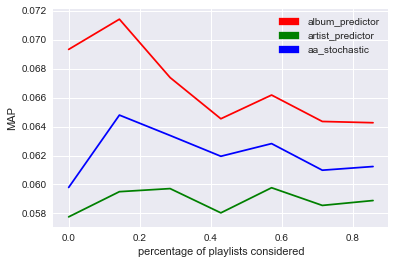

,playlist_id,playlist_id_tmp,track_ids,track_ids_not_mapped
playlist_id,,,,
50890,50890,10185451,"[3287441, 616698, 1907494, 1595301, 710110]",[]
16100,16100,6925084,"[408061, 1215853, 3258636, 2866388, 1041148]",[]
34340,34340,7976807,"[293740, 3361402, 3786726, 2931368, 1818594]",[]
56759,56759,5234120,"[1919018, 3408516, 1556434, 361143, 192585]",[]
1900,1900,6088892,"[316016, 1923925, 2139927, 2274257, 456568]",[]
37013,37013,5293517,"[1420987, 3470331, 3843001, 2536680, 3604235]",[]
2977,2977,5614292,"[3119256, 3696321, 925126, 3608068, 3502746]",[]
31700,31700,8797329,"[1764673, 1873729, 1300081, 207405, 3364542]",[]
32254,32254,10483815,"[3126418, 2739985, 2498691, 311090, 2265695]",[]


In [739]:
make_predictions(final_predictor, URM_normalize, target_playlists, target_tracks,
                 row_group=1000,
                 compute_MAP=True, test=test, num_to_tracks=num_to_tracks)

1 -> 0

# Prepare matrices for schwiftyness!
Yoooo we're gonna get schwiftyyyyy: print all the info necessaries for get_schwifty.cpp to work...

In [31]:
def print_similarity(matrix_to_print, directory, filename):
    matrix_to_print = matrix_to_print.tocoo()

    file = open(directory + "/" + filename + ".txt","w") 

    rows = matrix_to_print.row;
    cols = matrix_to_print.col;
    data = matrix_to_print.data;

    file.write("{0} {1}\n".format(matrix_to_print.shape[0], matrix_to_print.shape[1]))

    for i in range(0,len(rows)):
        file.write("{0} ".format(rows[i]))
    file.write("\n")

    for i in range(0,len(cols)):
        file.write("{0} ".format(cols[i]))
    file.write("\n")

    for i in range(0,len(data)):
        file.write("{0} ".format(data[i]))
    file.write("\n")

    file.close() 

In [32]:
def print_URM(urm, directory, filename):
    file = open(directory + "/" + filename + ".txt","w")
    
    urm_coo = urm.tocoo()

    rows = urm_coo.row;
    cols = urm_coo.col;
    data = urm_coo.data;

    file.write("{0} {1}\n".format(urm_coo.shape[0], urm_coo.shape[1]))

    for i in range(0,len(rows)):
        file.write("{0} ".format(rows[i]))
    file.write("\n")

    for i in range(0,len(rows)):
        file.write("{0} ".format(cols[i]))
    file.write("\n")

    for i in range(0,len(rows)):
        file.write("{0} ".format(data[i]))
    file.write("\n")
    
    for pl_id in target_playlists.playlist_id:
        file.write("{0} ".format(pl_id))
    file.write("\n")

    file.close() 

In [33]:
def print_test(urm, directory, filename):
    file = open(directory + "/" + filename + ".txt","w")
    
    urm_coo = urm.tocoo()

    rows = urm_coo.row;
    cols = urm_coo.col;

    file.write("{0} {1}\n".format(urm_coo.shape[0], urm_coo.shape[1]))

    for i in range(0,len(rows)):
        file.write("{0} ".format(rows[i]))
    file.write("\n")

    for i in range(0,len(rows)):
        file.write("{0} ".format(cols[i]))
    file.write("\n")

    file.close() 

In [34]:
def print_target_playlists(target_playlists, directory, filename):
    file = open(directory + "/" + filename + ".txt","w")
    
    file.write("{0}\n".format(len(target_playlists)))
    for pl_id in target_playlists.playlist_id:
        file.write("{0} ".format(pl_id))
    file.write("\n")
    
    file.close() 

In [35]:
def print_target_tracks(target_tracks, directory, filename):
    file = open(directory + "/" + filename + ".txt","w")
    
    file.write("{0}\n".format(len(target_tracks)))
    for tr_id in target_tracks.track_id:
        file.write("{0} ".format(tr_id))
    file.write("\n")
    
    file.close() 

In [36]:
schwifty_directory = "test1"

In [37]:
print_URM(URM_pow, schwifty_directory, "tracks_in_playlist")

In [ ]:
"""test['playlist_id_tmp'] = test['playlist_id']
test['track_id_tmp'] = test['track_id']
test['track_id'] = test['track_id'].apply(lambda x : track_to_num[x])
test['playlist_id'] = test['playlist_id'].apply(lambda x : playlist_to_num[x])"""

In [ ]:
"""
# Create a dataframe that maps a playlist to the set of its tracks
playlist_tracks_test = pd.DataFrame(test['playlist_id'].drop_duplicates())
playlist_tracks_test.index = test['playlist_id'].unique()
playlist_tracks_test['track_ids'] = test.groupby('playlist_id').apply(lambda x : x['track_id'].values)
playlist_tracks_test = playlist_tracks_test.sort_values('playlist_id')

# Create a dataframe that maps a track to the set of the playlists it appears into
track_playlists_test = pd.DataFrame(test['track_id'].drop_duplicates())
track_playlists_test.index = test['track_id'].unique()
track_playlists_test['playlist_ids'] = test.groupby('track_id').apply(lambda x : x['playlist_id'].values)
track_playlists_test = track_playlists_test.sort_values('track_id')

URM_test = get_URM(tracks, playlists, playlist_tracks_test, track_playlists_test, norm="no")"""

In [ ]:
#print_test(URM_test, schwifty_directory, "test")

In [ ]:
#print_target_tracks(target_tracks, schwifty_directory, "target_tracks")

In [ ]:
#print_target_playlists(target_playlists, schwifty_directory, "target_playlists")

In [38]:
TTM_dot_copy = TTM_dot.copy()

In [39]:
TTM_cosine_copy = TTM_cosine.copy()

In [40]:
TTM_UUM_cosine_copy = TTM_UUM_cosine.copy()

In [41]:
SYM_ALBUM_copy = SYM_ALBUM.copy()

In [42]:
SYM_ARTIST_copy = SYM_ARTIST.copy()

In [76]:
SYM_TAG_copy = SYM_TAG.copy()

In [ ]:
TTM_dot = TTM_dot_copy.copy()

In [ ]:
TTM_cosine = TTM_cosine_copy.copy()

In [ ]:
TTM_UUM_cosine = TTM_UUM_cosine_copy.copy()

In [ ]:
SYM_ALBUM = SYM_ALBUM_copy.copy()

In [ ]:
SYM_ARTIST = SYM_ARTIST_copy.copy()

In [ ]:
SYM_TAG = SYM_TAG_copy.copy()

In [43]:
from sklearn.preprocessing import normalize

In [44]:
TTM_dot = normalize(TTM_dot, norm='l2', axis=0)

In [45]:
TTM_cosine = normalize(TTM_cosine, norm='l2', axis=0)

In [46]:
TTM_UUM_cosine = normalize(TTM_UUM_cosine, norm='l2', axis=0)

In [47]:
SYM_ALBUM = normalize(SYM_ALBUM, norm='l1', axis=0)

In [48]:
SYM_ARTIST = normalize(SYM_ARTIST, norm='l2', axis=0)

In [77]:
SYM_TAG = normalize(SYM_TAG, norm='l2', axis=0)

In [49]:
#print_similarity(TTM_dot, schwifty_directory, "similarity_0")

In [50]:
#print_similarity(TTM_cosine, schwifty_directory, "similarity_1")

In [51]:
#print_similarity(TTM_UUM_cosine, schwifty_directory, "similarity_2")

In [52]:
#print_similarity(SYM_ALBUM, schwifty_directory, "similarity_3")

In [53]:
#print_similarity(SYM_ARTIST, schwifty_directory, "similarity_4")

In [54]:
from pandas import Series

def load_playlist_params(location, params_bitmask):
    content = None
    with open(os.path.join(location, 'playlist_params.txt'), 'r') as f:
        content = f.readlines()

    playlist_params = pd.DataFrame(playlists.playlist_id)
    p = 0
    for it,ch in enumerate(params_bitmask):
        param_name = "param_" + str(it)
        if ch == "1":
            p_list = list(map(float, content[p].strip().split(' ')))
            playlist_params[param_name] = Series(data=p_list, index=playlist_params.index)
            p += 1
        else:
            playlist_params[param_name] = 0

    return playlist_params

In [55]:
from subprocess import call

In [66]:
call(["./get_schwifty", "test1", "11111", "adadelta", "1000", "0.9", "0.3", "2"])

0

In [67]:
playlist_params = load_playlist_params("test1", "11111")
playlist_params[playlist_params.playlist_id.isin(target_playlists.playlist_id)]

,playlist_id,param_0,param_1,param_2,param_3,param_4
0,0,0.396839,0.444891,0.263535,1.407570,0.149888
4,4,0.452189,0.499419,0.310674,1.616780,0.164639
5,5,0.544483,0.578334,0.741585,0.371167,0.270944
6,6,0.297131,0.323084,0.201349,1.195050,0.106432
8,8,0.320824,0.300705,0.325097,0.776626,0.107159
23,23,0.254940,0.324306,0.188089,0.291868,0.137107
28,28,0.712384,0.708510,0.658350,2.113440,0.124849
38,38,0.558864,0.505409,0.472219,1.387100,1.369920
43,43,0.306144,0.343912,0.196970,0.793005,0.115241
54,54,0.347881,0.386460,0.229181,1.732680,0.126787


In [78]:
playlist_params = pd.DataFrame(playlists.playlist_id)
playlist_params["param_0"] = 1
playlist_params["param_1"] = 1
playlist_params["param_2"] = 1
playlist_params["param_3"] = 1
playlist_params["param_4"] = 1
playlist_params["param_5"] = 1

In [81]:
similarities = [TTM_dot, TTM_cosine, TTM_UUM_cosine, SYM_ALBUM, SYM_ARTIST]

predictions = make_predictions(test=test, target_playlists=target_playlists, urm=URM_pow,
                 similarities=similarities, playlist_params=playlist_params,
                 compute_MAP=True, row_group=1000, verbose=False)

6658
1000
0.0817233333333334
2000
0.08305499999999974
3000
0.08216444444444403
4000
0.08051249999999989
5000
0.08277933333333343
6000
0.08127000000000023
6658
0.08147892259937964


In [ ]:
0.0819

In [ ]:
def make_predictions(test=None, target_playlists=None, urm=None,
                     similarities=[], playlist_params=None,
                     compute_MAP=False, row_group=100, verbose=False):
    """
        Produces a prediction dataframe for "test", where each row corresponds to a playlist in "target_playlists".
        If compute_MAP is true, then it print the MAP every "row_group" playlists.
        It's optimized for doing dot products for different playlist at once.
            "row_group" is the number of playlists in each of these optimized dot products.
            The higher is row_group, the faster are the predictions but more memory is used.
            
        All predictions are done in the following way:
            bi
            
        Arguments:
            - test: needed for computing MAP
            - target_playlists: a dataframe containing the target playlists we want to predict for
            - urm: the urm used for making predictions
            - similarities: list with similarities used for making predictions
            - playlist_params: dataframe containing parameters used for doing predictions. The name comvention
                is the following: the parameter for SYM_0 is "param_0", etc...
    """
    # Create predictions dataframe
    predictions = pd.DataFrame(target_playlists)
    predictions.index = target_playlists['playlist_id']
    predictions['track_ids'] = [np.array([]) for i in range(len(predictions))]
    predictions['track_ids_not_mapped'] = [np.array([]) for i in range(len(predictions))]
    ttracks = set(target_tracks['track_id'].values)
    if compute_MAP:
        test_good = get_playlist_track_list2(test)
        test_good.index = test_good.playlist_id.apply(lambda pl_id: playlist_to_num[pl_id])
        print(len(test_good))
    
    # This is the sum of all the AP of the playlists.
    # When we print the MAP, we divide "sum_ap" by the number of considered playlists.
    sum_ap = 0
    
    # Let's start the predictions!
    row_start = 0
    while row_start < len(target_playlists):
        # We'll do dot products for all playlists in "target_playlists" from "row_start" to "row_end"
        row_end = row_start + row_group if row_start + row_group <= len(target_playlists) else len(target_playlists)
        
        # "pl_group" is the set of the playlists that we want to make prediction for
        pl_group = target_playlists[row_start:row_end]
        
        # Now we need to build a matrix where, for each playlist in "pl_group", we take the correspondent URM row slice
        rows_URM = []
        for pl_id in pl_group.playlist_id:
            rows_URM += [urm[pl_id,:]]
        composed_URM = scipy.sparse.vstack(rows_URM, 'csr')
        
        # Compute predictions for current playlist group: here we do all the smart dot products...
        simil_ar = []
        for SYM in similarities:
            simil_ar.append(np.array(np.divide(SYM.dot(composed_URM.transpose()).transpose().todense(), SYM.sum(axis=1).transpose() + 1)))
            #simil_ar.append(np.array(SYM.dot(composed_URM.transpose()).transpose().todense()))
            #simil_ar.append(np.array(cosine_similarity(SYM, composed_URM).transpose()))
                            
        # Now we should consider one playlist at a time, take its own personalized parameters and make the prediction
        for i,pl_id in enumerate(pl_group.playlist_id):
            # Tracks that we know are in the playlist (so we shouldn't recommend them)
            pl_tracks = set(playlist_tracks.loc[pl_id]['track_ids'])
            
            # Retrieve parameters
            params = []
            for it,SYM in enumerate(similarities):
                params.append(playlist_params.loc[pl_id]["param_" + str(it)])

            simil = params[0] * simil_ar[0][i]
            for p in range(1,len(simil_ar)):
                simil += params[p] * simil_ar[p][i]
            sorted_ind = simil.argsort()[::-1]

            # Predict...
            pred_not_mapped = []
            pred = []
            i = 0
            while i < len(sorted_ind) and len(pred) < 5:
                tr = sorted_ind[i]
                if (tr in ttracks) and (tr not in pl_tracks) and (num_to_tracks[tr] not in pred):
                    pred_not_mapped.append(tr)
                    pred.append(num_to_tracks[tr])
                i+=1
            
            predictions.loc[pl_id] = predictions.loc[pl_id].set_value('track_ids_not_mapped', np.array(pred_not_mapped))
            predictions.loc[pl_id] = predictions.loc[pl_id].set_value('track_ids', np.array(pred))
            
            # Update MAP
            if compute_MAP:
                correct = 0
                ap = 0
                for it, t in enumerate(pred):
                    tr_ids = test_good.loc[pl_id]['track_ids']
                    if t in tr_ids:
                        correct += 1
                        ap += correct / (it+1)
                ap /= len(pred)
                sum_ap += ap
        
        # Update "row_start" to "row_end" and proceed to next pl_group
        row_start = row_end
        
        print(row_start)
        if compute_MAP:
            print(sum_ap / row_start)
            
    return predictions

## for predictions

In [ ]:
pr_copy = predictions.copy(deep=True)

In [ ]:
predictions['playlist_id'] = predictions['playlist_id_tmp']

In [ ]:
predictions = predictions.drop("playlist_id_tmp", axis=1)
predictions = predictions.drop("track_ids_not_mapped", axis=1)

In [ ]:
predictions.head()

In [ ]:
# Make the dataframe friendly for output -> convert np.array in string
predictions['track_ids'] = predictions['track_ids'].apply(lambda x : ' '.join(map(str, x)))
predictions.to_csv('results.csv', index=False)